In [1]:
"""
PINN for the 1D Heat Equation using TensorFlow.

This script demonstrates how to solve the 1D heat equation using a
Physics-Informed Neural Network (PINN).

The equation is: ∂u/∂t - α * ∂²u/∂x² = 0
Domain: x in [0, 1], t in [0, 1]
Initial Condition (IC): u(x, 0) = sin(πx)
Boundary Conditions (BC): u(0, t) = 0, u(1, t) = 0
Thermal Diffusivity (α): 0.1
"""

'\nPINN for the 1D Heat Equation using TensorFlow.\n\nThis script demonstrates how to solve the 1D heat equation using a\nPhysics-Informed Neural Network (PINN).\n\nThe equation is: ∂u/∂t - α * ∂²u/∂x² = 0\nDomain: x in [0, 1], t in [0, 1]\nInitial Condition (IC): u(x, 0) = sin(πx)\nBoundary Conditions (BC): u(0, t) = 0, u(1, t) = 0\nThermal Diffusivity (α): 0.1\n'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time


In [3]:
# Setting seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# PROBLEM PARAMETERS
ALPHA = 0.1
X_MIN, X_MAX = 0.0, 1.0
T_MIN, T_MAX = 0.0, 1.0

# Number of training points
N_physics = 20000  # Points inside the domain for the PDE loss
N_bc = 1000       # Points on the boundary (x=0, x=1)
N_ic = 1000       # Points on the initial time slice (t=0)

# Training parameters
EPOCHS = 15000
LEARNING_RATE = 1e-3

In [4]:
# Definition of PINN
def build_model(num_hidden_layers=4, num_neurons_per_layer=32):
    model = tf.keras.Sequential()
    # Input layer (x, t)
    model.add(tf.keras.layers.InputLayer(input_shape=(2,)))
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation='tanh'))
    model.add(tf.keras.layers.Dense(1, activation=None))
    return model

In [5]:
# GENERATEING COLLOCATION (TRAINING) POINTS
# Physics points (inside the domain)
x_phys = tf.random.uniform((N_physics, 1), X_MIN, X_MAX)
t_phys = tf.random.uniform((N_physics, 1), T_MIN, T_MAX)

# Initial condition points (t=0)
x_ic = tf.random.uniform((N_ic, 1), X_MIN, X_MAX)
t_ic = tf.zeros((N_ic, 1))

# True IC values: u(x, 0) = sin(πx)
u_ic_true = tf.sin(np.pi * x_ic)

# Boundary condition points (x=0 and x=1)
t_bc = tf.random.uniform((N_bc, 1), T_MIN, T_MAX)
x_bc_0 = tf.zeros((N_bc, 1))
x_bc_1 = tf.ones((N_bc, 1))

# True BC values (u=0 on boundaries)
u_bc_true = tf.zeros((N_bc, 1))


In [6]:
# LOSS FUNCTION
def get_residual(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u = model(tf.concat([x, t], axis=1))

        # First derivatives
        du_dx = tape2.gradient(u, x)
        du_dt = tape2.gradient(u, t)

    # Second derivative
    d2u_dx2 = tape.gradient(du_dx, x)

    del tape # Drop the tapes to free up memory
    del tape2

    residual = du_dt - ALPHA * d2u_dx2
    return residual

In [7]:
def compute_loss(model, x_phys, t_phys, x_ic, t_ic, u_ic_true, x_bc_0, x_bc_1, t_bc, u_bc_true):
    # Physics loss
    residual = get_residual(model, x_phys, t_phys)
    loss_phys = tf.reduce_mean(tf.square(residual))

    # Initial condition loss
    u_pred_ic = model(tf.concat([x_ic, t_ic], axis=1))
    loss_ic = tf.reduce_mean(tf.square(u_ic_true - u_pred_ic))

    # Boundary condition loss
    u_pred_bc_0 = model(tf.concat([x_bc_0, t_bc], axis=1))
    u_pred_bc_1 = model(tf.concat([x_bc_1, t_bc], axis=1))
    loss_bc = tf.reduce_mean(tf.square(u_pred_bc_0 - u_bc_true)) + \
              tf.reduce_mean(tf.square(u_pred_bc_1 - u_bc_true))

    total_loss = loss_phys + loss_ic + loss_bc
    return total_loss, loss_phys, loss_ic, loss_bc


In [8]:
# TRAINING LOOP
pinn_model = build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

@tf.function
def train_step(x_p, t_p, x_i, t_i, u_i, x_b0, x_b1, t_b, u_b):

    with tf.GradientTape() as tape:
        total_loss, _, _, _ = compute_loss(pinn_model, x_p, t_p, x_i, t_i, u_i, x_b0, x_b1, t_b, u_b)

    gradients = tape.gradient(total_loss, pinn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables))
    return total_loss

print("Starting training...")
start_time = time.time()
for epoch in range(EPOCHS):
    train_step(x_phys, t_phys, x_ic, t_ic, u_ic_true, x_bc_0, x_bc_1, t_bc, u_bc_true)

    if (epoch + 1) % 1000 == 0:
        total_loss, loss_p, loss_i, loss_b = compute_loss(pinn_model, x_phys, t_phys, x_ic, t_ic, u_ic_true, x_bc_0, x_bc_1, t_bc, u_bc_true)
        print(f"Epoch [{epoch+1}/{EPOCHS}], "
              f"Loss: {total_loss.numpy():.4e}, "
              f"Physics: {loss_p.numpy():.4e}, "
              f"IC: {loss_i.numpy():.4e}, "
              f"BC: {loss_b.numpy():.4e}")

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Starting training...
Epoch [1000/15000], Loss: 5.5673e-04, Physics: 1.8835e-04, IC: 1.2036e-04, BC: 2.4803e-04
Epoch [2000/15000], Loss: 2.3574e-04, Physics: 9.3467e-05, IC: 3.8178e-05, BC: 1.0409e-04
Epoch [3000/15000], Loss: 1.1893e-04, Physics: 6.9417e-05, IC: 1.0010e-05, BC: 3.9506e-05
Epoch [4000/15000], Loss: 6.6562e-05, Physics: 4.4548e-05, IC: 3.1496e-06, BC: 1.8864e-05
Epoch [5000/15000], Loss: 3.9715e-05, Physics: 2.8312e-05, IC: 1.8388e-06, BC: 9.5650e-06
Epoch [6000/15000], Loss: 3.1321e-05, Physics: 2.1610e-05, IC: 1.3748e-06, BC: 8.3366e-06
Epoch [7000/15000], Loss: 2.2560e-05, Physics: 1.6919e-05, IC: 8.5772e-07, BC: 4.7835e-06
Epoch [8000/15000], Loss: 1.8167e-05, Physics: 1.3837e-05, IC: 6.2275e-07, BC: 3.7065e-06
Epoch [9000/15000], Loss: 1.4804e-05, Physics: 1.1462e-05, IC: 4.4711e-07, BC: 2.8954e-06
Epoch [10000/15000], Loss: 1.1931e-05, Physics: 9.3469e-06, IC: 3.2669e-07, BC: 2.2574e-06
Epoch [11000/15000], Loss: 3.2479e-04, Physics: 2.1958e-05, IC: 8.8810e-05, BC

In [ ]:
# Analytical solution for validation
def analytical_solution(x, t, alpha):
    return np.sin(np.pi * x) * np.exp(-alpha * np.pi**2 * t)


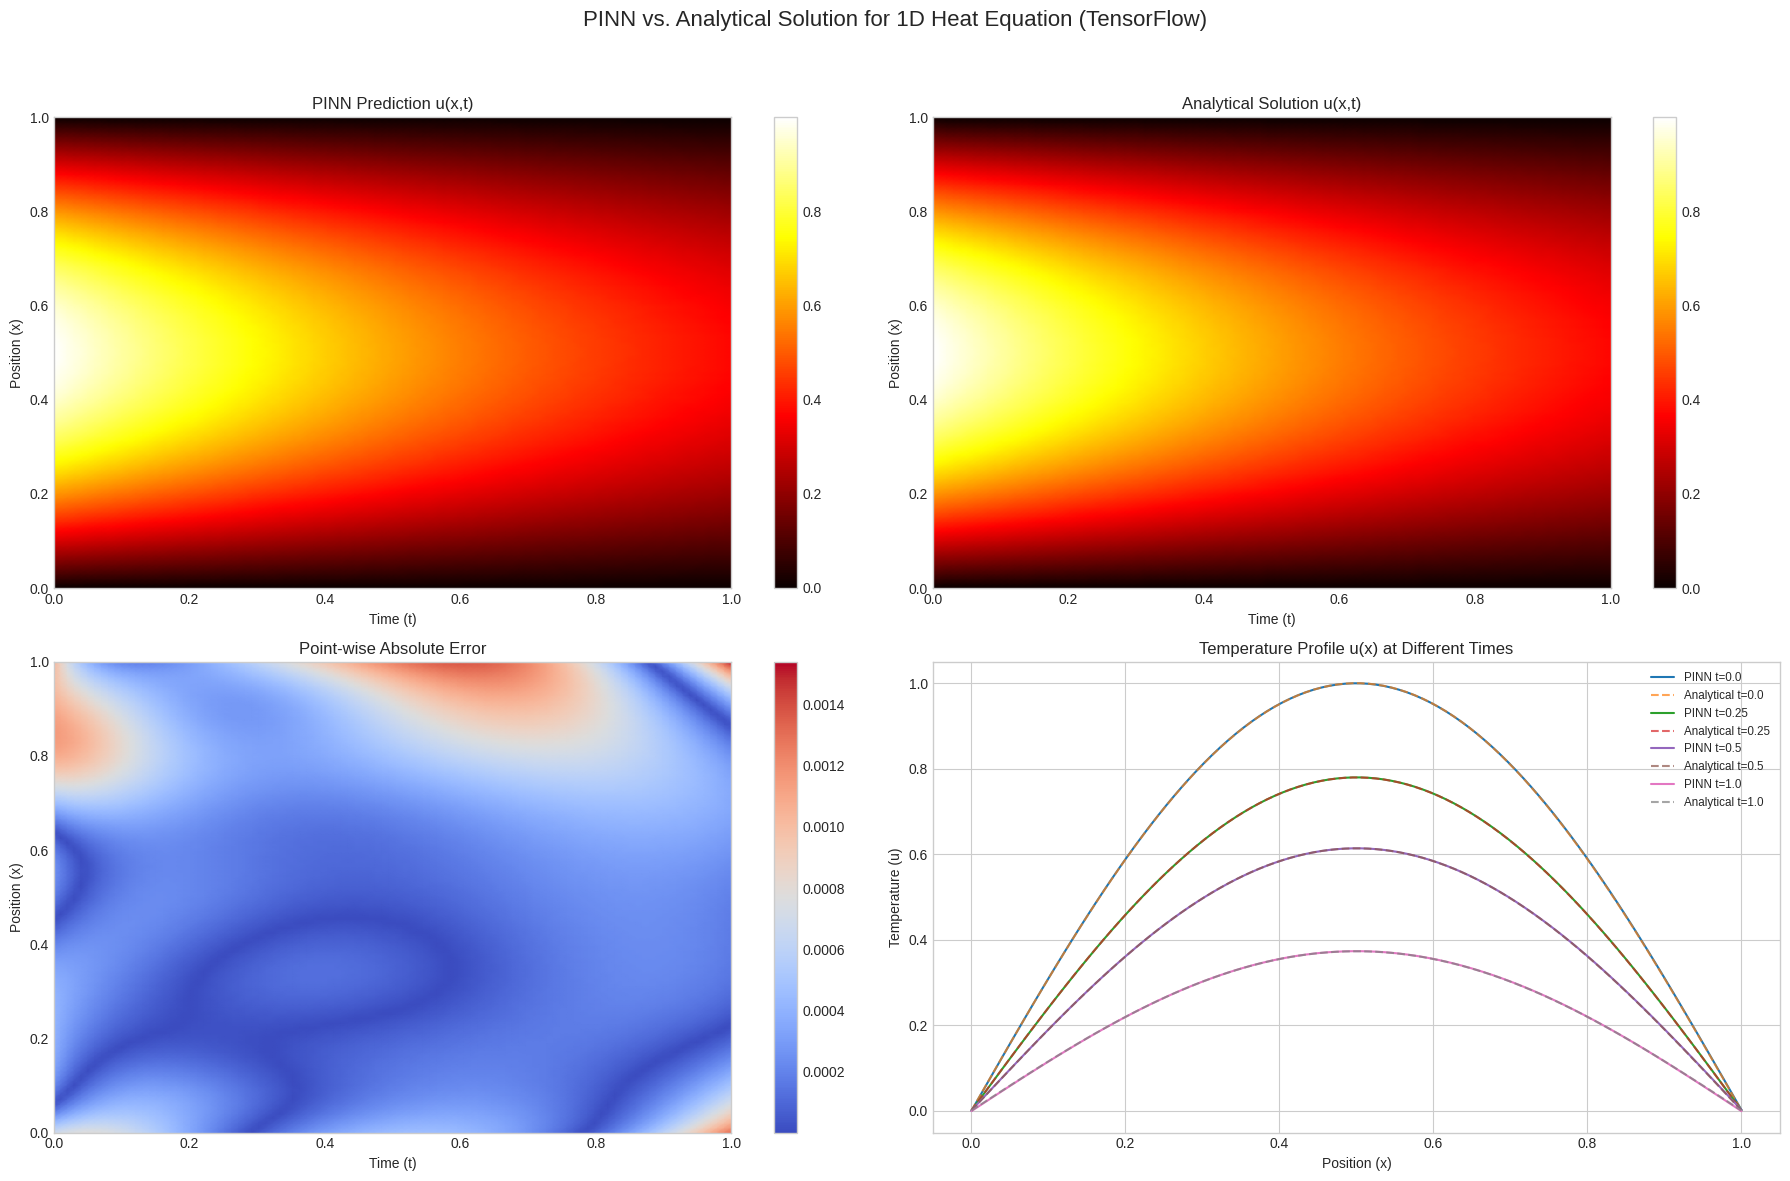

In [10]:
# VISUALIZEING THE RESULTS
# Creating a grid for plotting
N_plot = 100
x_plot = np.linspace(X_MIN, X_MAX, N_plot)
t_plot = np.linspace(T_MIN, T_MAX, N_plot)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)

# Flattening grid for network input
x_flat = tf.constant(X_grid.flatten(), dtype=tf.float32)[:, tf.newaxis]
t_flat = tf.constant(T_grid.flatten(), dtype=tf.float32)[:, tf.newaxis]

# Getting predictions from the PINN
u_pred_flat = pinn_model(tf.concat([x_flat, t_flat], axis=1))
U_pred = tf.reshape(u_pred_flat, X_grid.shape).numpy()

# Calculating the analytical solution on the grid
U_analytical = analytical_solution(X_grid, T_grid, ALPHA)

# Calculating the point-wise error
Error = np.abs(U_pred - U_analytical)

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(18, 12))
fig.suptitle('PINN vs. Analytical Solution for 1D Heat Equation (TensorFlow)', fontsize=16)

# 1. PINN Prediction
ax1 = fig.add_subplot(2, 2, 1)
c1 = ax1.pcolormesh(T_grid, X_grid, U_pred, cmap='hot', shading='gouraud')
fig.colorbar(c1, ax=ax1)
ax1.set_title('PINN Prediction u(x,t)')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Position (x)')

# 2. Analytical Solution
ax2 = fig.add_subplot(2, 2, 2)
c2 = ax2.pcolormesh(T_grid, X_grid, U_analytical, cmap='hot', shading='gouraud')
fig.colorbar(c2, ax=ax2)
ax2.set_title('Analytical Solution u(x,t)')
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Position (x)')

# 3. Point-wise Error
ax3 = fig.add_subplot(2, 2, 3)
c3 = ax3.pcolormesh(T_grid, X_grid, Error, cmap='coolwarm', shading='gouraud')
fig.colorbar(c3, ax=ax3)
ax3.set_title('Point-wise Absolute Error')
ax3.set_xlabel('Time (t)')
ax3.set_ylabel('Position (x)')

# 4. Temperature profiles at different times
ax4 = fig.add_subplot(2, 2, 4)
times_to_plot = [0.0, 0.25, 0.5, 1.0]
for t_val in times_to_plot:
    t_idx = np.argmin(np.abs(t_plot - t_val))
    ax4.plot(x_plot, U_pred[t_idx, :], label=f'PINN t={t_val}')
    ax4.plot(x_plot, U_analytical[t_idx, :], '--', label=f'Analytical t={t_val}', alpha=0.7)

ax4.set_title('Temperature Profile u(x) at Different Times')
ax4.set_xlabel('Position (x)')
ax4.set_ylabel('Temperature (u)')
ax4.legend(fontsize='small')
ax4.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()